## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [1]:
# Put your imports here
import time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

from statsmodels.multivariate.pca import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
data_folder = './data/'
task_1_folder = data_folder + 'Task_1/'
task_2_folder = data_folder + 'Task_2/'

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,220 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

__Preliminary data loading and inspection__

In [11]:
#We load the dataset
county = pd.read_csv(task_1_folder + 'acs2015_county_data.csv')

#We explore it..
display(county.head(2))
display(county.tail(2))

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5


,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3
3219,72153,Puerto Rico,Yauco,39474,19047,20427,99.5,0.5,0.0,0.0,...,1.6,0.7,3.1,24.6,8923,68.0,27.6,4.4,0.0,27.1


In [12]:
#Little peak at the different columns
county.columns

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [15]:
#Check if any NaN within the dataset (just in case)
print('There is', county.isnull().sum().sum(), 'NaN(s) in the dataset.')
county.loc[[548, 2673],['State', 'County', 'Income', 'IncomeErr', 'ChildPoverty']] #manually displayed after automatic search

There is 3 NaN(s) in the dataset.


,State,County,Income,IncomeErr,ChildPoverty
548,Hawaii,Kalawao,66250.0,9909.0,NaN
2673,Texas,Loving,NaN,NaN,0.0


There 'NaN' entries are not handled for the moment, they won't affect the following computations. We keep in mind that they may require to be removed if needed.

Here we are interested in the dependency between the Income per capita ($) and the self employment percentage (\%). We can see that there is no NaN values in our variable of interest.

__A) You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,220 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?__

Text(0,0.5,'Income per Capita')

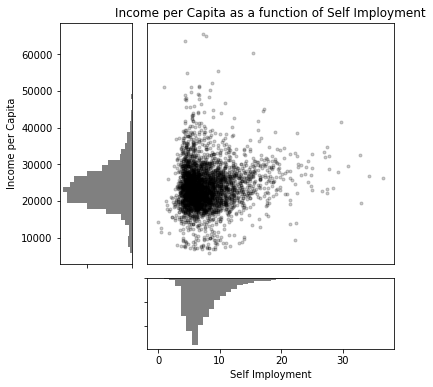

In [28]:
#Correlation between SelfEmployement and IncomePerCapita visualization

#set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(county['SelfEmployed'], county['IncomePerCap'], 'ok', markersize=3, alpha=0.2)
main_ax.set_title('Income per Capita as a function of Self Imployment')

# remove middle plot axes
main_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

main_ax.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the left edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)   # labels along the left edge are off

# histogram on the attached axes
x_hist.hist(county['SelfEmployed'], 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()
x_hist.set_xlabel('Self Imployment')

y_hist.hist(county['IncomePerCap'], 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()
y_hist.set_ylabel('Income per Capita')

Several way exist to investigate dependancy between two variables. First, we can look to Pearson correlation that indicates the extent to which two variables are linearly related. 

But what if the variable are related but non-linearly ? In this case Rank correlation coefficients such as Spearman need to be used. It measure the extent to which, as one variable increases, the other variable tends to increase, without requiring that increase to ne represented by a linear relationship.

In [38]:
#We look for Pearson correlation
print('Pearson coefficient:', "%.3f" % county.corr(method='pearson')['IncomePerCap']['SelfEmployed'])

Pearson coefficient: 0.087


In [39]:
#We look for Spearman correlation
print('Spearman coefficient:', "%.3f" % county.corr(method='spearman')['IncomePerCap']['SelfEmployed'])

Spearman coefficient: 0.056


We can see that both values are really weak (<0.1) and thus we can conclude that these two variables are not correlated for this dataset.

Another way to look for dependency is OLS regression. If the coefficient for the independant variable is statistically different from 0, it significates that these variable have a statistical signifiant effect. But in order to have meaningfull results several assumptions must hold :

A1. The linear regression model is “linear in parameters.”

A2. There is a random sampling of observations.

A3. The conditional mean should be zero.

A4. There is no multi-collinearity (or perfect collinearity).

A5. Spherical errors: There is homoscedasticity and no autocorrelation

A6: Optional Assumption: Error terms should be normally distributed.

From here, there is two assumptions that we cannot confirm. First, we do not know if the model is linear in parameters (it seems not from the visualization) and second we are not sure that there is not multicollinearity.



In [40]:
#We look to the result of regression between IncomePerCap and SelfEmployment
result=sm.ols(formula="IncomePerCap ~ SelfEmployed",data=county).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           IncomePerCap   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     24.70
Date:                Sun, 18 Nov 2018   Prob (F-statistic):           7.05e-07
Time:                        21:47:13   Log-Likelihood:                -32676.
No. Observations:                3220   AIC:                         6.536e+04
Df Residuals:                    3218   BIC:                         6.537e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.288e+04    246.159     92.967   

Just to observe the regression output, we chose to run the OLS regression. We have been asked to not add additionnal features so our model just take self employment as independant variable.

From the outputs above we can see that the coefficient is significantly non-null since P>|t| = 0.000. The coefficient is 22 880 but we cannot say from it that an increase of 1% in self employment will lead to an increase of Income per Capita of 22 880. Why ?
First, by looking to the R-squarred coefficient. It shows that this model can only explain 8% of the variance of Income Per Capita. It is way too low. Second, because we do not take any supplementary feature in account which could lead to Omitted Variable Bias (when a statistical model leaves out one or more relevant variables). This bias results in the model attributing the effect of the missing variables to the estimated effects of the included variable (Self employment here).

What could be done in order to solve this is to integer new feature from dataset. Partial Least Squares Regression (PLS) or Principal Components Analysis (PCA) could then be use to cut the number of predictors to a smaller set of uncorrelated components. 

In conclusion, we can say that there is no statistical dependency between IncomePerCap and SelfEmployment.

__B) The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.__

__C) In which state within set A is the observed effect of self-employment on per-capita income the strongest?__

__D) Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.__

## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

__A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1.__

In [19]:
#Load the data
shelter_data = pd.read_csv(task_2_folder + 'aac_intakes_outcomes.csv')[['animal_type', 'intake_year', 'intake_condition', 
                                                                        'intake_number', 'intake_type', 'sex_upon_intake',
                                                                        'age_upon_intake_(years)', 'time_in_shelter_days',
                                                                        'sex_upon_outcome', 'age_upon_outcome_(years)',
                                                                        'outcome_type']]
shelter_data.head(5)

,animal_type,intake_year,intake_condition,intake_number,intake_type,sex_upon_intake,age_upon_intake_(years),time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(years),outcome_type
0,Dog,2017,Normal,1.0,Stray,Neutered Male,10.0,0.588194,Neutered Male,10.0,Return to Owner
1,Dog,2014,Normal,2.0,Public Assist,Neutered Male,7.0,1.259722,Neutered Male,7.0,Return to Owner
2,Dog,2014,Normal,3.0,Public Assist,Neutered Male,6.0,1.113889,Neutered Male,6.0,Return to Owner
3,Dog,2014,Normal,1.0,Owner Surrender,Neutered Male,10.0,4.970139,Neutered Male,10.0,Transfer
4,Dog,2013,Injured,1.0,Public Assist,Neutered Male,16.0,0.119444,Neutered Male,16.0,Return to Owner


In [20]:
#Get features and labels
X_categorical = shelter_data.drop(['outcome_type'], axis=1)
y_categorical = shelter_data[['outcome_type']]

In [21]:
#Convert categorical variables to dummy variables (indicator variables)
X = pd.get_dummies(X_categorical)
y = pd.get_dummies(y_categorical)[['outcome_type_Adoption']]
X.head(5)

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,2017,1.0,10.0,0.588194,10.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2014,2.0,7.0,1.259722,7.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2014,3.0,6.0,1.113889,6.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2014,1.0,10.0,4.970139,10.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2013,1.0,16.0,0.119444,16.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [22]:
#Convert categorical variables to dummy variables (indicator variables) (cont.)
y.head(5)

,outcome_type_Adoption
0,0
1,0
2,0
3,0
4,0


In [23]:
#Split the data into training and test sets

def split_data(X, y, prop_test):
    
    total_size = len(y)
    test_size = int(total_size * prop_test)
    
    #get a random set of indices for the test set
    test_indices = np.random.randint(low=0, high=total_size, size=(test_size,))
    
    #take these indices for the test
    test_X = X.loc[test_indices].reset_index(drop=True)
    test_y = y.loc[test_indices].reset_index(drop=True)

    #drop these indices from training
    train_X = X.drop(X.index[test_indices]).reset_index(drop=True)
    train_y = y.drop(y.index[test_indices]).reset_index(drop=True)
    
    return train_X, train_y, test_X, test_y

In [24]:
#Generation of training and testing datasets
train_X, train_y, test_X, test_y = split_data(X, y['outcome_type_Adoption'], 0.2)

In [25]:
#Standardize the values of each feature in the data to have mean 0 and variance 1
#Operation on the training set independently of the testing set, in order to keep them uncorrelated
train_X.describe()

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
count,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,...,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000
mean,2015.434979,1.126732,2.107214,16.823912,2.141870,0.004200,0.371398,0.569298,0.055104,0.004016,...,0.298544,0.317643,0.159963,0.139255,0.084580,0.117106,0.122134,0.355472,0.320693,0.084580
std,1.304145,0.456716,2.886773,42.427942,2.893383,0.064671,0.483182,0.495178,0.228185,0.063245,...,0.457623,0.465563,0.366575,0.346215,0.278258,0.321549,0.327443,0.478660,0.466746,0.278258
min,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,0.164384,1.108333,0.246575,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,1.000000,1.000000,4.978472,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,1.000000,3.000000,13.343229,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,2018.000000,13.000000,25.000000,1606.194444,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Standarization formula: 

    for each index i in the set

    x_i = (x_i - x.mean)/x.std

In [26]:
#Standardize the values of each feature in the data to have mean 0 and variance 1 (cont.)
train_X_std = (train_X - train_X.mean())/train_X.std()
test_X_std = (test_X - test_X.mean())/test_X.std()
train_X_std.describe()

#note that the std is 1 as wanted and the mean is so small, it tends towards 0

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
count,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,...,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04,6.524000e+04
mean,1.559575e-13,5.087834e-14,1.886775e-13,2.003364e-15,2.494262e-13,-1.714627e-14,-3.116946e-15,4.677340e-14,-1.664715e-14,4.425345e-15,...,-7.622542e-15,-4.068447e-14,-4.870508e-14,4.853346e-14,-2.906763e-14,1.706247e-14,8.595908e-15,2.896715e-14,-7.213975e-15,-2.906763e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.867107e+00,-2.774854e-01,-7.299549e-01,-3.965291e-01,-7.402647e-01,-6.494248e-02,-7.686498e-01,-1.149683e+00,-2.414889e-01,-6.349860e-02,...,-6.523797e-01,-6.822759e-01,-4.363727e-01,-4.022212e-01,-3.039627e-01,-3.641934e-01,-3.729926e-01,-7.426404e-01,-6.870814e-01,-3.039627e-01
25%,-1.100321e+00,-2.774854e-01,-6.730111e-01,-3.704063e-01,-6.550443e-01,-6.494248e-02,-7.686498e-01,-1.149683e+00,-2.414889e-01,-6.349860e-02,...,-6.523797e-01,-6.822759e-01,-4.363727e-01,-4.022212e-01,-3.039627e-01,-3.641934e-01,-3.729926e-01,-7.426404e-01,-6.870814e-01,-3.039627e-01
50%,-3.335353e-01,-2.774854e-01,-3.835473e-01,-2.791896e-01,-3.946486e-01,-6.494248e-02,-7.686498e-01,8.697918e-01,-2.414889e-01,-6.349860e-02,...,-6.523797e-01,-6.822759e-01,-4.363727e-01,-4.022212e-01,-3.039627e-01,-3.641934e-01,-3.729926e-01,-7.426404e-01,-6.870814e-01,-3.039627e-01
75%,1.200036e+00,-2.774854e-01,3.092677e-01,-8.203750e-02,2.965837e-01,-6.494248e-02,1.300963e+00,8.697918e-01,-2.414889e-01,-6.349860e-02,...,1.532826e+00,1.465660e+00,-4.363727e-01,-4.022212e-01,-3.039627e-01,-3.641934e-01,-3.729926e-01,1.346526e+00,1.455409e+00,-3.039627e-01
max,1.966822e+00,2.599704e+01,7.930233e+00,3.746047e+01,7.900139e+00,1.539800e+01,1.300963e+00,8.697918e-01,4.140913e+00,1.574814e+01,...,1.532826e+00,1.465660e+00,2.291584e+00,2.486156e+00,3.289827e+00,2.745752e+00,2.680978e+00,1.346526e+00,1.455409e+00,3.289827e+00


__B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.__

In [27]:
#Train the classifier on the training sets
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(train_X_std, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
#Function to threshold the outcome probabilities
def threshold(prediction, thresh):
    if prediction < thresh:
        return 0
    return 1

In [29]:
#Predict with 0.5 threshold
prediction_probs = pd.DataFrame(logistic.predict_proba(test_X_std))
pred_thresh_50 = prediction_probs[1].map(lambda r: threshold(r, 0.5))

__Confusion matrix:__

                               Predicted
                          1        |         0
                  ------------------------------------
                1 | said 1, was 1  | said 0, was 1
                  |   (true pos)   |  (false neg)
        Actual    | ----------------------------------
                0 | said 1, was 0  | said 0, was 0
                  |   (false pos)  |  (true neg)



In [30]:
#Functions to create and parse the confusion matrix
def confusion_matrix(test_y, pred):
    nb_values = len(test_y)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(nb_values):
        if test_y[i] == 1:
            if pred[i] == 1:
                tp += 1
            else:
                fn += 1
        else:
            if pred[i] == 1:
                fp += 1
            else:
                tn += 1
                
    return np.array([[tp, fn], [fp, tn]])

def parse_confusion_matrix(confusion_matrix):
    tp = confusion_matrix[0][0]
    tn = confusion_matrix[1][1]
    fp = confusion_matrix[1][0]
    fn = confusion_matrix[0][1]
    return tp, tn, fp, fn

Confusion matrix values: 
 [[5430 1182]
 [1675 7647]] 



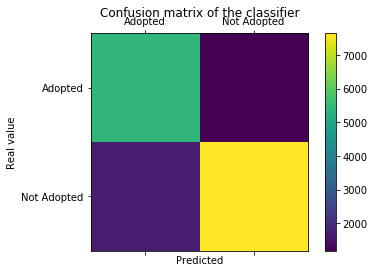

In [31]:
#Generate values for confusion matrix
conf_matrix = confusion_matrix(test_y, pred_thresh_50)
print('Confusion matrix values: \n', conf_matrix, '\n')

#Plot confusion matrix with a colorscale representation
labels = ['Adopted', 'Not Adopted']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

plt.title('Confusion matrix of the classifier')

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.xlabel('Predicted')
plt.ylabel('Real value')
plt.show()

__Formulas__:

_Accuracy: ratio of correctly predicted observation to the total observations. Great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same._

     accuracy = (True pos +True neg) / (True pos + False pos + False neg + True neg) 
     
_Precision: ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate._

     precision = True pos/(True pos + False pos)
     
_Recall: ratio of correctly predicted positive observations to the all observations in actual class - yes_
     
     recall = True Pos/(True Pos + False Neg)
     
_F1 Score: weighted average of Precision and Recall. Takes both false positives and false negatives into account. Usually more useful than accuracy, especially if you have an uneven class distribution. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall._
     
     F1-score =  2*(Recall * Precision) / (Recall + Precision)
     
(Source: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

In [32]:
#Functions to evaluate the model:
#...  Note that for divisions, if the bottom is 0, then the top is also 0,
#...  (the strictly positive top is included in the bottom sum),
#...  so we have 0/0 ~ 1

#Calculate the accurace
def get_accuracy(confusion_matrix):
    tp, tn, fp, fn = parse_confusion_matrix(confusion_matrix)
    return (tp + tn)/(tp + tn + fp + fn)

#Calculate the precision
def get_precision(confusion_matrix, positive):
    tp, tn, fp, fn = parse_confusion_matrix(confusion_matrix)
    
    if positive:
        all_pos = (tp + fp)
        if all_pos == 0:
            return 1
        return tp/all_pos
    
    all_neg = (tn + fn)
    if all_neg == 0:
        return 1
    return tn/all_neg

#Calculate the recall
def get_recall(confusion_matrix, positive):
    tp, tn, fp, fn = parse_confusion_matrix(confusion_matrix)
    
    if positive:
        pos = (tp + fn)
        if pos == 0:
            return 1
        return tp/pos
    
    neg = tn + fp
    if neg == 0:
        return 1
    return tn/neg

#Calculate the F1 score
def get_f1(recall, precision):
    if recall + precision == 0:
        return 1
    return (2 * recall * precision)/(recall + precision)

#Get overall performance evaluation
def get_performance_eval(confusion_matrix, thresh, print_info, hide = False):
        
    accuracy = get_accuracy(confusion_matrix)
    
    pos_precision = get_precision(confusion_matrix, True)
    pos_recall = get_recall(confusion_matrix, True)
    pos_f1 = get_f1(pos_recall, pos_precision)
    
    neg_precision = get_precision(confusion_matrix, False)
    neg_recall = get_recall(confusion_matrix, False)
    neg_f1 = get_f1(neg_recall, neg_precision)
    
    if print_info == True:
        print('Stats--------------------------------------------------')
        print(' ')
        print('Threshold: ', thresh)
        print(' ')
        print('Matrix: ')
        print(confusion_matrix)
        print('')
        print('Accuracy:  ', accuracy)
        print(' ')
        print('              Positive         / Negative')
        print('Precision: ', pos_precision, "/", neg_precision)
        print('Recall:    ', pos_recall, '/', neg_recall)
        print('F1-Score:  ', pos_f1, '/', neg_f1)
        print('-------------------------------------------------------')
        
    if hide == False :    
        return [thresh, accuracy, pos_precision, neg_precision, pos_recall, neg_recall, pos_f1, neg_f1]

In [33]:
#Show performance evaluation with the base threshold of 0.5
get_performance_eval(conf_matrix, 0.5, True, True)

Stats--------------------------------------------------
 
Threshold:  0.5
 
Matrix: 
[[5430 1182]
 [1675 7647]]

Accuracy:   0.8206978787498431
 
              Positive         / Negative
Precision:  0.7642505277973258 / 0.8661230037376826
Recall:     0.8212341197822142 / 0.8203175284273762
F1-Score:   0.7917183057519867 / 0.8425982039557048
-------------------------------------------------------


In [34]:
#Try a range of thresholds between 0 and 1 (by steps of 0.05)
stats = []
for thresh in np.arange(0.0, 1.05, 0.05):
    #try each threshold on the probs
    pred = prediction_probs[1].map(lambda r: threshold(r, thresh))
    
    #and evaluate the model
    matrix = confusion_matrix(test_y, pred)
    stat = get_performance_eval(matrix, thresh, False)
    
    #add it to the list for comparison
    stats.append(stat)

stats_df = pd.DataFrame(stats,
                        columns=['Threshold', 'Accuracy','+Precision', '-Precision', '+Recall', '-Recall', '+F1', '-F1'])
stats_df

,Threshold,Accuracy,+Precision,-Precision,+Recall,-Recall,+F1,-F1
0,0.00,0.414962,0.414962,1.000000,1.000000,0.000000,0.586534,0.000000
1,0.05,0.585791,0.500456,0.988164,0.995009,0.295537,0.665958,0.454996
2,0.10,0.712627,0.593834,0.964909,0.972928,0.527998,0.737518,0.682521
3,0.15,0.740994,0.621635,0.954188,0.960375,0.585389,0.754739,0.725617
4,0.20,0.758504,0.641078,0.945911,0.949788,0.622828,0.765480,0.751100
5,0.25,0.775009,0.661337,0.937738,0.938294,0.659193,0.775839,0.774173
6,0.30,0.792143,0.686399,0.924315,0.918935,0.702210,0.785825,0.798098
7,0.35,0.807644,0.713341,0.910510,0.896854,0.744368,0.794640,0.819099
8,0.40,0.817560,0.738080,0.893413,0.868572,0.781377,0.798027,0.833648
9,0.45,0.822330,0.755369,0.880436,0.845735,0.805728,0.798002,0.841427


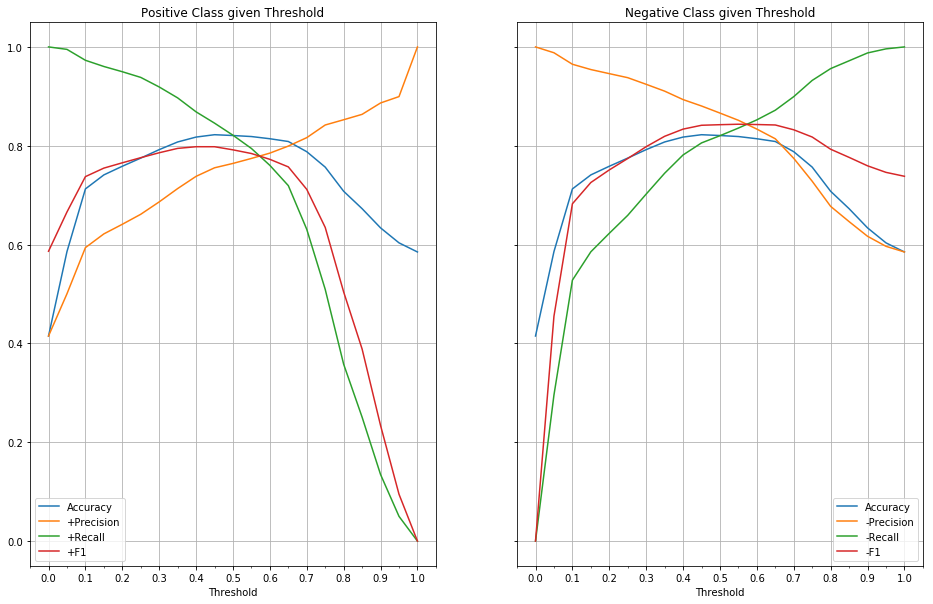

In [35]:
#Plot the performance for different thresholds
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[1].xaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(0.05))

stats_df.plot(kind='line', x='Threshold', y=['Accuracy', '+Precision', '+Recall', '+F1'], 
              ax=axs[0], grid=True, title='Positive Class given Threshold', figsize=(16, 10))
stats_df.plot(kind='line', x='Threshold', y=['Accuracy', '-Precision', '-Recall', '-F1'], 
              ax=axs[1], grid=True, title='Negative Class given Threshold')

We will use the negative class, because it has both higher precision and recall. 

We want to absolutely minimize false negatives (killing animals that actually might have gotten adopted), so we want to __maximize precision__ (which is inversely proportionate to the number of false negatives). But of course this alone is not enough (because precision can be maximized by setting all negatives to 0 and refusing to kill any animal, which is not possible), so we also __take into account recall__, to make sure we aren't keeping animals that won't ever be adopted. These two values intersect at their mutually maximal point with __threshold=0.56__.

In [36]:
#Evaluation of prediction with threshold=0.56
#Performance for the best selected threshold
pred = prediction_probs[1].map(lambda r: threshold(r, 0.56))
matrix = confusion_matrix(test_y, pred)
get_performance_eval(matrix, 0.56, True, True)

Stats--------------------------------------------------
 
Threshold:  0.56
 
Matrix: 
[[5203 1409]
 [1506 7816]]

Accuracy:   0.8170578636877118
 
              Positive         / Negative
Precision:  0.7755254136234908 / 0.8472628726287262
Recall:     0.7869026013309135 / 0.8384466852606737
F1-Score:   0.7811725846407928 / 0.8428317248072464
-------------------------------------------------------


__C) Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.__

_Note that we chose accuracy as our evalution metric_

In [37]:
#Functions for feature selection

#function to select the feature without which accuracy is highest
def get_worst_feature(X_train, X_test, y_train, y_test, thresh):
    
    #prepare trainer
    logistic = LogisticRegression(solver='lbfgs')
    
    #prepare trackers
    features = X_train.columns
    worst_feat = features[0]
    worst_acc = 0.0
    
    #try training with each feature removed at a time, and drop the one resulting in the highest accuracy
    # (training is okay even without it)
    for feature in features:
        X_train_new = X_train.drop(feature, axis=1)
        X_test_new = X_test.drop(feature, axis=1)
        logistic.fit(X_train_new, y_train)
        prediction_probs = pd.DataFrame(logistic.predict_proba(X_test_new))
        pred = prediction_probs[1].map(lambda r: threshold(r, thresh))
        matrix = confusion_matrix(y_test, pred)
        accuracy = get_accuracy(matrix)
        
        if accuracy > worst_acc:
            worst_feat = feature
            worst_acc = accuracy
    
    return worst_feat

#Function to remove features until only the k best ones are left 
def reduce_features(X_train, X_test, y_train, y_test, k, thresh):

    while X_train.shape[1] > k:
        worst_feature = get_worst_feature(X_train, X_test, y_train, y_test, thresh)
        X_train.drop(worst_feature, axis=1, inplace=True)
        X_test.drop(worst_feature, axis=1, inplace=True)
    return X_train, X_test

In [38]:
#Functions for cross-validation

#get k indice arrays splitting the data evenly
def k_way_split_indices(X, y, k):
    
    total_size = len(y)
    sample_size = int(total_size * (1/k))
    
    #get the indices
    indices = X.index.tolist()
    
    #shuffle them for randomness
    np.random.shuffle(indices)
    
    #split the shuffled indices into even groups
    indice_arrays = []
    
    for sample_nb in range(k):
        indice_arrays.append(indices[sample_nb * sample_size: (sample_nb + 1) * sample_size])
    
    return indice_arrays

#do k-fold crossvalidation on a given classifier and return the average of the results 
def k_fold_cross_validate(X, y, k, thresh, classifier):
        
    #split the data into k groups
    indice_arrays = k_way_split_indices(X, y, k)
    
    stats = []
    
    #for each group of indices
    for i in range(k):
        
        indices = indice_arrays[i]
        
        #the indices mark the validation data
        test_X = X.loc[indices].reset_index(drop=True)
        test_y = y.loc[indices].reset_index(drop=True)

        #the rest is training data
        train_X = X.drop(X.index[indices]).reset_index(drop=True)
        train_y = y.drop(y.index[indices]).reset_index(drop=True)
        
        #train on the training data
        classifier.fit(train_X, train_y)
        
        #predict on the validation set
        prediction_probs = pd.DataFrame(classifier.predict_proba(test_X))
        pred_thresh = prediction_probs[1].map(lambda r: threshold(r, thresh))
        
        #save the model evaluation
        matrix = confusion_matrix(test_y, pred_thresh)
        stat = get_performance_eval(matrix, thresh, False)
        stats.append(stat)
        
    #average the model evaluations
    stats_average = [sum(stat)/k for stat in zip(*stats)]
    
    return stats_average

In [39]:
#Do cross validation on a set of models, each time with fewer features
def vary_features(X_train, X_test, y_train, y_test, thresh, ks, fold):
    
    #classifier
    logistic = LogisticRegression(solver='lbfgs')
    
    nb_datapoints = len(y_test)
    
    stats = []
    
    #for each number of features
    for k in ks:
        
        #remove features until size is k
        X_train, X_test = reduce_features(X_train, X_test, y_train, y_test, k, thresh)
        
        #get evaluation through cross validation
        stat_k = k_fold_cross_validate(X_train, y_train, fold, thresh, logistic)
        
        #save the size and features with the stats
        stat_k[0] = k
        stat_k.append(X_train.columns.tolist())
        stats.append(stat_k)
    
    return pd.DataFrame(stats
                , columns=['k', 'Accuracy','+Precision', '-Precision', '+Recall', '-Recall', '+F1', '-F1', 'Columns'])

In [40]:
#Selected threshold from B
thresh = 0.56

#We order these in descending order for the feature reduction
ks = [30, 25, 20, 15, 10, 5, 1]
feature_reduction = vary_features(train_X_std.copy(), test_X_std.copy(), train_y, test_y, thresh, ks, 5)

In [41]:
#Show performance in function of number of features
feature_reduction

,k,Accuracy,+Precision,-Precision,+Recall,-Recall,+F1,-F1,Columns
0,30,0.818838,0.784446,0.844261,0.788203,0.841281,0.786310,0.842763,"[intake_year, intake_number, time_in_shelter_d..."
1,25,0.818731,0.784421,0.844071,0.787881,0.841335,0.786139,0.842695,"[intake_year, intake_number, time_in_shelter_d..."
2,20,0.818562,0.783923,0.844202,0.788191,0.840810,0.786038,0.842494,"[intake_year, intake_number, time_in_shelter_d..."
3,15,0.818884,0.784923,0.843996,0.787557,0.841851,0.786191,0.842895,"[intake_year, intake_number, time_in_shelter_d..."
4,10,0.818424,0.783970,0.843875,0.787607,0.840989,0.785768,0.842420,"[intake_year, intake_number, time_in_shelter_d..."
5,5,0.800322,0.750707,0.840219,0.790357,0.807686,0.769968,0.823597,"[time_in_shelter_days, age_upon_outcome_(years..."
6,1,0.658553,0.626999,0.673467,0.475481,0.792688,0.540805,0.728223,[sex_upon_outcome_Spayed Female]


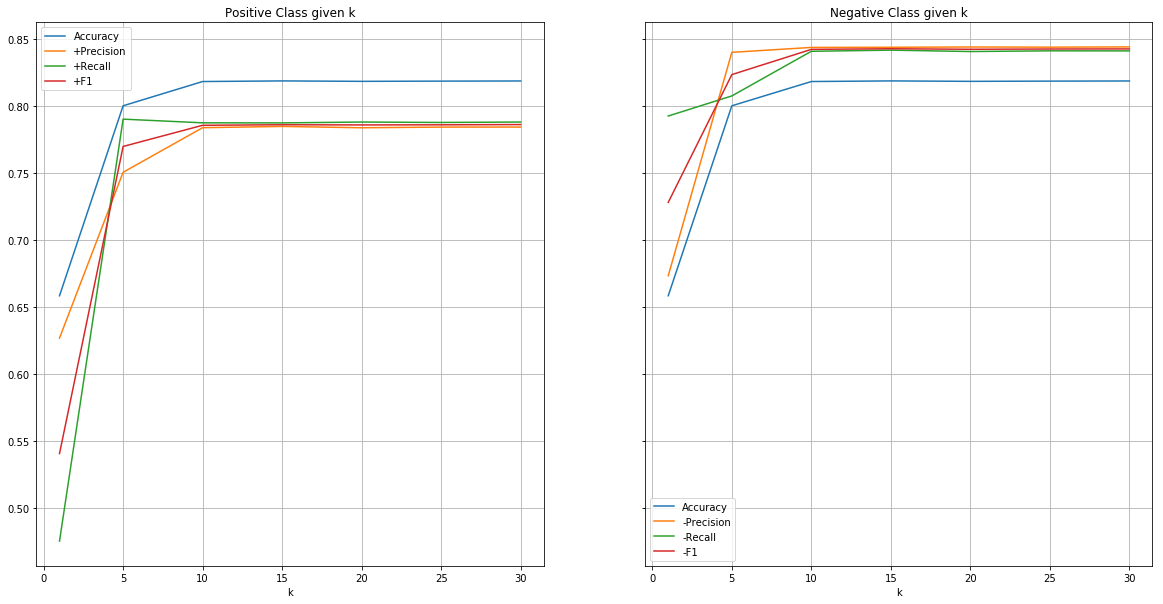

In [42]:
#Plot the performance as a function of the number of features
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

feature_reduction.plot(kind='line', x='k', y=['Accuracy', '+Precision', '+Recall', '+F1'], 
              ax=axs[0], grid=True, title='Positive Class given k', figsize=(20, 10))
feature_reduction.plot(kind='line', x='k', y=['Accuracy', '-Precision', '-Recall', '-F1'], 
              ax=axs[1], grid=True, title='Negative Class given k')

The best k is clearly 5, giving us the best precision, recall and accuracy ratio to number of features, while trying to reduce the complexity of the model as much as possible. Once we have 10 features, the performance teaches a plateau that is less than +10% increase compared to k=5.

Note that if we are willing to sacrifice more ressources to get better precision, then 10 would also be perfectly acceptable.

__Interpretation of top-5 features__

In [43]:
#List top 5 features
top_feat = feature_reduction.at[5, 'Columns']
top_feat

['time_in_shelter_days',
 'age_upon_outcome_(years)',
 'intake_type_Owner Surrender',
 'sex_upon_outcome_Neutered Male',
 'sex_upon_outcome_Spayed Female']

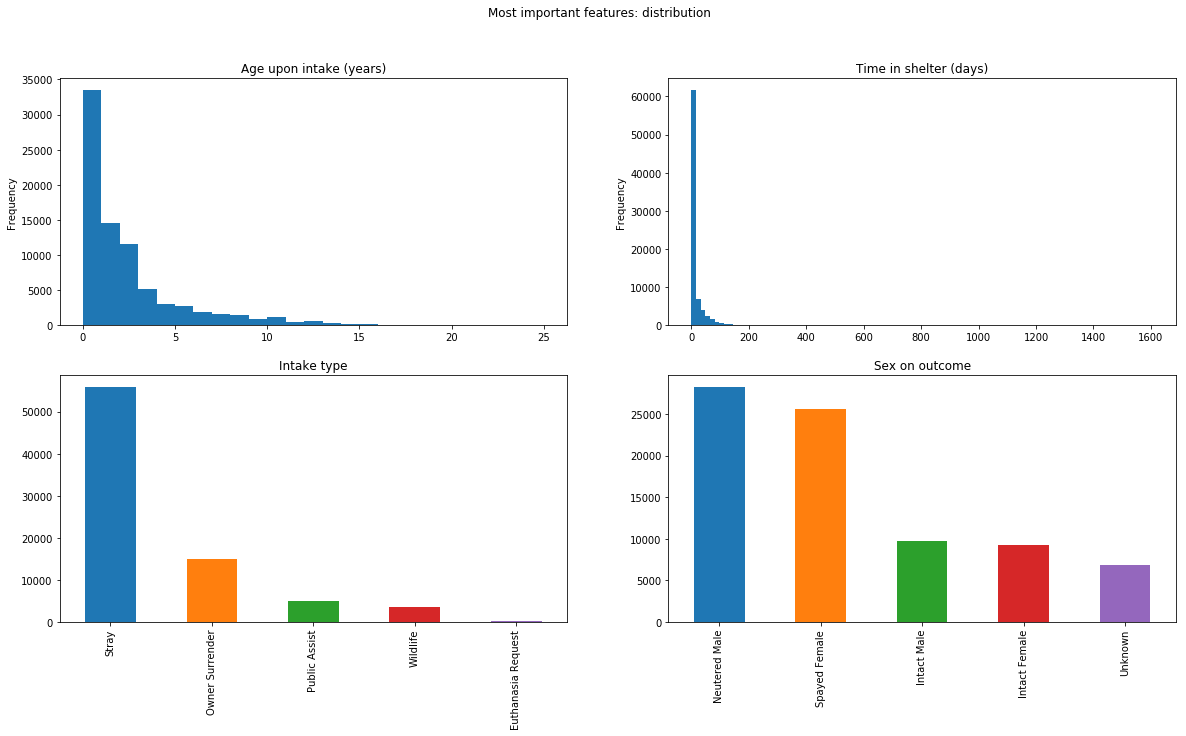

In [52]:
#Show distribution of top 5 features
fig, axs = plt.subplots(2, 2)
fig.suptitle('Most important features: distribution')
X_categorical['age_upon_intake_(years)'].plot(kind='hist', bins=25,ax=axs[0][0], figsize=(20, 10), title='Age upon intake (years)')
X_categorical['time_in_shelter_days'].plot(kind='hist', bins=100, ax=axs[0][1], title = 'Time in shelter (days)')
X_categorical['intake_type'].value_counts().plot(kind='bar', ax=axs[1][0], title='Intake type')
X_categorical['sex_upon_outcome'].value_counts().plot(kind='bar', ax=axs[1][1], title='Sex on outcome')

__Impact of the features__

There seems to be 4 basic categories that matter to whether an animal will be adopted or not:

1) The age of the animal: People prefer to adopt young animals. Most animal adopted are less than 1 year old.

2) The time spent in the shelter: The more time an animal stays in a shelter, the less people are willing to adopt it. It may be a psychological thing where it everybody didn't want it, something wrong with it. Moreover, an animal that stayed for a long time in a shelter may be sad and stressed, an appear less appealing to people.

3) The intake type: Most of the animal that are in the shelter are stray animals. This can affect the adoption since it affects the mental health of the animal. In another way, maybe "something wrong with it" if the previous owner abandoned him.

4) The sex and reproductive status on outcome: Neutered or sprayed animal should be adopted easier since it may require less money investisements in the future (vet visite, etc.).

__D) Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.__

In [45]:
#Fine-tuning the parameters
#n_estimators = nb trees in forest

#test each pair (#trees, max-depth) in a given range of #trees and depths (grid search)
stats = []
matrices = []
for n in range(90, 100):
    for depth in range(10, 15):
        forest = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=0)
        stat = k_fold_cross_validate(train_X_std, train_y, 5, thresh, forest)
        
        #add #trees and depth to stats
        stat[0] = n
        stat.append(depth)
        stats.append(stat)
        matrices.append(matrix)
        
performances = pd.DataFrame(stats, columns=['n_estimators', 'Accuracy','+Precision', 
                                            '-Precision', '+Recall', '-Recall', 
                                            '+F1', '-F1', 'max_depth'])


In [46]:
#Show performance of different models (width and depth)
performances

,n_estimators,Accuracy,+Precision,-Precision,+Recall,-Recall,+F1,-F1,max_depth
0,90,0.845708,0.805376,0.877519,0.837642,0.851608,0.821127,0.864325,10
1,90,0.848743,0.808297,0.880684,0.842042,0.853629,0.824785,0.866919,11
2,90,0.851318,0.808558,0.885508,0.849601,0.852573,0.828562,0.868722,12
3,90,0.851855,0.808372,0.886830,0.851537,0.852055,0.829375,0.869081,13
4,90,0.854062,0.810466,0.889115,0.854800,0.853539,0.832032,0.870959,14
5,91,0.847701,0.806514,0.880294,0.841863,0.851997,0.823782,0.865897,10
6,91,0.849877,0.807224,0.883948,0.847407,0.851742,0.826795,0.867527,11
7,91,0.851288,0.808593,0.885424,0.849517,0.852589,0.828538,0.868689,12
8,91,0.851809,0.809219,0.885910,0.850030,0.853143,0.829087,0.869196,13
9,91,0.853801,0.810651,0.888398,0.853669,0.853928,0.831590,0.870815,14


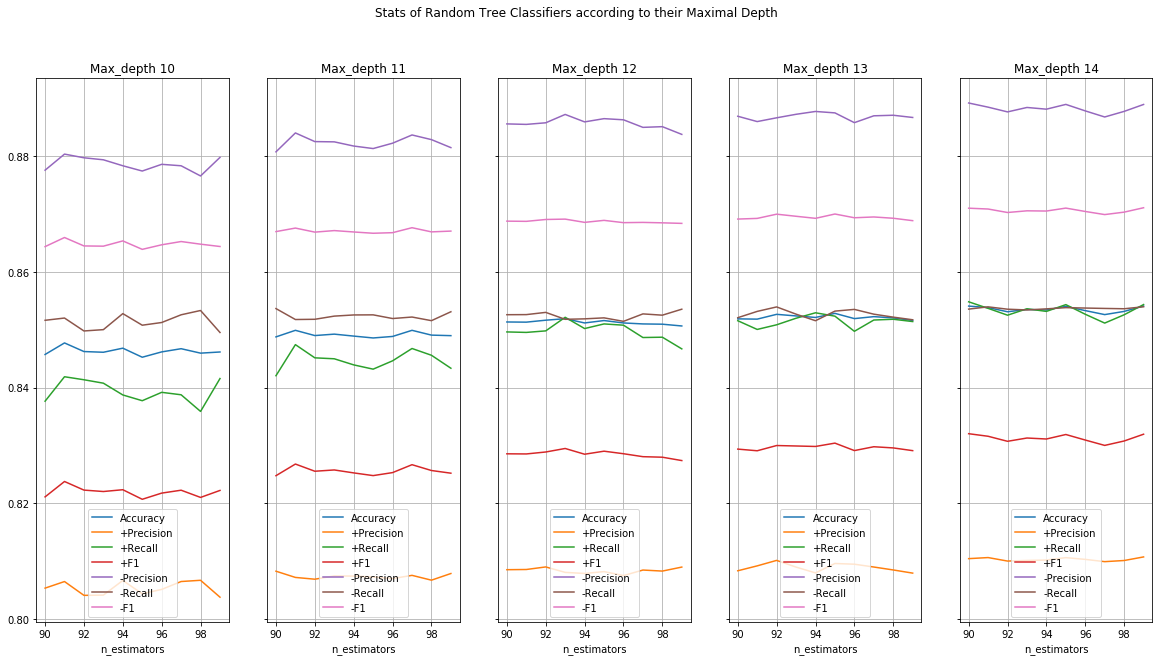

In [51]:
#plot the data
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True)
fig.suptitle('Stats of Random Tree Classifiers according to their Maximal Depth')
performances[performances['max_depth'] == 10]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[0], grid=True, title='Max_depth 10', figsize=(20, 10))

performances[performances['max_depth'] == 11]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[1], grid=True, title='Max_depth 11', figsize=(20, 10))

performances[performances['max_depth'] == 12]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[2], grid=True, title='Max_depth 12', figsize=(20, 10))

performances[performances['max_depth'] == 13]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[3], grid=True, title='Max_depth 13', figsize=(20, 10))

performances[performances['max_depth'] == 14]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[4], grid=True, title='Max_depth 14', figsize=(20, 10))

* Best number of trees: 94

* Best max depth: 12 (Avoid overfitting)

In [48]:
#train and compare with threshold 0.56

thresh = 0.56

print('--------------------------Random Forest Classifier-------------------------------')
start_time_forest = time.time()
forest = RandomForestClassifier(n_estimators=94, max_depth=12, random_state=0)
forest.fit(train_X_std, train_y)
prediction_probs_forest = pd.DataFrame(forest.predict_proba(test_X_std))
pred_forest = prediction_probs_forest[1].map(lambda r: threshold(r, thresh))

matrix = confusion_matrix(test_y, pred_forest)
get_performance_eval(matrix, 0.56, True, True)
print('Elapsed time for random forests: ', time.time() - start_time_forest)
print('\n')
print('-------------------------Logistic Regression (as seen above)---------------------')

#Evaluation of prediction with threshold=0.56
start_time_log = time.time()
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(train_X_std, train_y)
prediction_probs_logistic = pd.DataFrame(logistic.predict_proba(test_X_std))
pred_log = prediction_probs_logistic[1].map(lambda r: threshold(r, thresh))
matrix = confusion_matrix(test_y, pred_log)
get_performance_eval(matrix, 0.56, True, True)
print('Elapsed time for logistic regression: ', time.time() - start_time_log)

--------------------------Random Forest Classifier-------------------------------
Stats--------------------------------------------------
 
Threshold:  0.56
 
Matrix: 
[[5112 1500]
 [1248 8074]]

Accuracy:   0.8275385967114347
 
              Positive         / Negative
Precision:  0.8037735849056604 / 0.8433256736996031
Recall:     0.7731397459165155 / 0.8661231495387256
F1-Score:   0.788159111933395 / 0.8545723962743438
-------------------------------------------------------
Elapsed time for random forests:  4.112356185913086


-------------------------Logistic Regression (as seen above)---------------------
Stats--------------------------------------------------
 
Threshold:  0.56
 
Matrix: 
[[5203 1409]
 [1506 7816]]

Accuracy:   0.8170578636877118
 
              Positive         / Negative
Precision:  0.7755254136234908 / 0.8472628726287262
Recall:     0.7869026013309135 / 0.8384466852606737
F1-Score:   0.7811725846407928 / 0.8428317248072464
-------------------------------------

We see that the forest is slightly more precise, but takes more time.

This makes sense because a random forest classifer needs to build trees, which takes more time than simple logistic regression. 